In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# part 1: ChIPseq

### step 1: building the index

bowtie2-build chr19.fa bowtie_index/chr19

### step 2: map the reads back to the genome, make bam files

for sample in CTCF_ER4 CTCF_G1E input_ER4 input_G1E
do
  bowtie2 -x ../bowtie_index/chr19 -U ${sample}.fastq -S ${sample}.sam -p 6
  samtools view -bSo ${sample}.bam ${sample}.sam
  samtools sort ${sample}.bam -o ${sample}.sorted.bam
  samtools index ${sample}.sorted.bam
done

### step 3: Calling peaks

macs2 callpeak -t CTCF_ER4.bam  -c input_ER4.bam --format=BAM --name=ER4 --gsize=61000000 --tsize=36

macs2 callpeak -t CTCF_G1E.bam  -c input_G1E.bam --format=BAM --name=G1E --gsize=61000000 --tsize=36

### step 4: differential binding

G1E is before differentiation
ER4 is after differentiation
so the -v flag tells me what is in A that is NOT in B. 
so if i want to find out what is gained:
    I have to do ER4 as A and G1E as B
and if i want to find out what is lost:
    I have to do G1E as A and ER4 as B


bedtools intersect -v -a ER4_peaks.narrowPeak -b G1E_peaks.narrowPeak > gain.bed

bedtools intersect -v -a G1E_peaks.narrowPeak -b ER4_peaks.narrowPeak > loss.bed

### step 5: Feature overlapping

-wa	Write the original entry in A for each overlap.


ok so you dummy we want the complete region in G1e or ER4 at each place that it overlaps with a feature on the other file that has the features (opening the file reveals that 'features' means introns, exons, promoters etc)


but which of the ER/G1 files do i want to use here?

Im thinking that I should use the ER4_peaks.narrowPeak because I only want the places in the sample where CTCF was binding

bedtools intersect -wa -a Mus_musculus.GRCm38.94_features.bed -b G1E_peaks.narrowPeak | cut -f 4 | sort | uniq -c > overlap_G1E.bed
bedtools intersect -wa -a Mus_musculus.GRCm38.94_features.bed -b ER4_peaks.narrowPeak | cut -f 4 | sort | uniq -c > overlap_ER4.bed

Results from above step:
G1E:
    84 exon
    307 intron
    54 promoter
ER4:
    101 exon
    341 intron
    67 promoter

wc loss.bed 
output: 57
wc gain.bed
output: 124

features = ('exon','intron','promoter')
direction = ('loss', 'gain')
G1E_val2 = (124,57)
ER4_val2 = (57,124)
y2_pos = (1,2)
y_pos = (1,2,3)
G1E_val = (84, 307, 54)
ER4_val = (101, 341, 67)


fig, ax = plt.subplots(2,2)
ax[0,0].bar( y_pos, G1E_val)
ax[0,0].set_xticks(y_pos)
ax[0,0].set_xticklabels(features)
ax[0,0].set_xlabel("Features")
ax[0,0].set_ylabel("Number of Binding Sites")
ax[0,0].set_title("Feature Binding for G1E")


ax[1,0].bar( y_pos, ER4_val)
ax[1,0].set_xticks(y_pos)
ax[1,0].set_xticklabels(features)
ax[1,0].set_xlabel("Features")
ax[1,0].set_ylabel("Number of Binding Sites")
ax[1,0].set_title("Feature Binding for ER4")


ax[0,1].bar( y2_pos, G1E_val2)
ax[0,1].set_xticks(y2_pos)
ax[0,1].set_xticklabels(direction)
ax[0,1].set_ylabel("Number of Binding Sites")
ax[0,1].set_title("Binding change relative to G1E")

ax[1,1].bar( y2_pos, ER4_val2)
ax[1,1].set_xticks(y2_pos)
ax[1,1].set_xticklabels(direction)
ax[1,1].set_xlabel("Features")
ax[1,1].set_ylabel("Number of Binding Sites")
ax[1,1].set_title("Binding change relative to ER4")


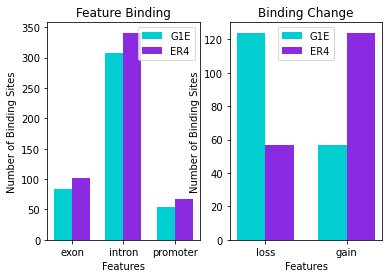

In [11]:
features = ('exon','intron','promoter')
direction = ('loss', 'gain')
G1E_val2 = (124,57)
ER4_val2 = (57,124)
y2_pos = (0,1)
y_pos = (0,1,2)
G1E_val = (84, 307, 54)
ER4_val = (101, 341, 67)

x = np.arange(len(features))
x2 = np.arange(len(direction))
width = 0.35

fig, ax = plt.subplots(1,2)
rects1 = ax[0].bar(x - width/2, G1E_val, width, label='G1E', color = 'darkturquoise')
rects2 = ax[0].bar(x + width/2, ER4_val, width, label='ER4', color = 'blueviolet')
ax[0].set_xticks(y_pos)
ax[0].set_xticklabels(features)
ax[0].set_xlabel("Features")
ax[0].set_ylabel("Number of Binding Sites")
ax[0].set_title("Feature Binding")
ax[0].legend()

rects1 = ax[1].bar(x2 - width/2, G1E_val2, width, label='G1E', color = 'darkturquoise')
rects2 = ax[1].bar(x2 + width/2, ER4_val2, width, label='ER4', color = 'blueviolet')
ax[1].set_xticks(y2_pos)
ax[1].set_xticklabels(direction)
ax[1].set_xlabel("Features")
ax[1].set_ylabel("Number of Binding Sites")
ax[1].set_title("Binding Change")
ax[1].legend()

# part 2: Motif discovery

### step 1: downlead meme motif databases and finding only 100 strongest peaks

sort -k 5 -n ER4_peaks.narrowPeak | tail -n 100 > sortedER4_peaks

### step2: getting sequences

bedtools getfasta -fi CTCF_ER4.fastq -bed sortedER4_peaks > sorterER4_peaks.fast

didnt work AT ALL GOD DAMNIT. it didnt like the chr19 so trying this

cut -f 2,3,4,5,6,7,8,9 sortedER4_peaks > finished100peaks

bedtools getfasta -fi CTCF_ER4.fastq -bed finished100peaks > sorterER4_peaks.fast

ok so that fixed nothing

PLOT TWIST IM HELLA DUMB IT TURNS OUT I WAS USING THE WRONG FASTA FILE

bedtools getfasta -fi chr19.fa -bed sortedER4_peaks > sorterER4_peaks.fa

new error: "The requested fasta database file (chr19.fa) could not be opened. Exiting!"

bedtools getfasta -fi chr19.fa -bed g1e/sortedER4_peaks > g1e/sorterER4_peaks.fa

get wrecked computer I win in the end

### step 3: meme chip commands and options

meme-chip -meme-maxw 20 -oc test_file sorterER4_peaks.fa

### step 4: TomTom

tomtom test_file/combined.meme motif_databases/JASPAR/JASPAR_CORE_2016.meme > tomtom_file

sort -k 5 -n tomtom_out/tomtom.txt | head -n 1 > sorted_tomtom

that didnt work

sort -k 5 -n tomtom_out/tomtom.txt > sorted_tomtom

that also didnt work: the scientific notation

sort -k 5 -g tomtom_out/tomtom.txt | head -n 2 > sorted_tomtom

output:  MA0139.1